In [2]:
import funzioni02 as f2
import funzioni01 as f1
import qiskit.quantum_info as qi
from copy import deepcopy
import numpy as np
import qiskit.ignis.mitigation.measurement as mc
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts
plt.rcParams['figure.figsize'] = [15, 10]

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_sim_jakarta = sim_noisy_jakarta 
backend = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

### definisco tutti i circuiti

In [58]:
### definisco i parametri fissati per la realizzazione del grafico
shots=32000
reps=4  # al massimo 10
precision=40
steps=42
backend_aus=backend_sim_jakarta
check=["4copy_check", [0,2,4,6]]
evo_type="column_evolution" # "column_evolution" or "complete_evolution" or "trotter_steps"
measure_mitigation="yes" #"yes" or "no"

### definisco i valori di steps corrispondenti ai punti che volgio acquisire
time_range=np.linspace(0.01,np.pi,20)
n_t=len(time_range)

### creo tutti i circuiti
qcs_times=[]
qcs_times_na=[]

### le liste qcs_steps e qcs_steps_na conterranno tutti i circuiti di evoluzione reps volte


for time in time_range:
    qcs = []
    
    for _ in range(reps):

        if check!=[]:
            qcs_aus, qcs_na = f2.evolution_tomo(type=evo_type, N_steps=steps, tempo=time, precision=precision, initial_state='110', check=check)
            qcs = qcs + qcs_aus
            

        else:
            qcs_aus = f2.evolution_tomo(type=evo_type, N_steps=steps, tempo=time, precision=precision, initial_state='110', check=check)
            qcs = qcs + qcs_aus
        
    qcs_times.append(qcs)
    qcs_times_na.append(qcs_na)


            

In [59]:
if measure_mitigation=="yes":
    qcs_calibs, meas_calibs = f2.calibration_cirquits(evo_type+"_remake", check[1], check="yes", check_type="4copy_check")
    state_lables = f2.bin_list(3+len(check[1]))

In [60]:
jobs_evo=[]

for qcs in qcs_times:
    job=execute(qcs, backend=backend_aus, shots=shots)
    jobs_evo.append(job)

if measure_mitigation=="yes":
    job_cal=execute(meas_calibs, backend=backend_aus, shots=shots)
    job_cal_our=execute(qcs_calibs, backend=backend_aus, shots=shots)

In [61]:
jobs_evo_result = {}
for i in range(len(jobs_evo)):
    job=jobs_evo[i]
    s = "%d" %(i)
    jobs_evo_result[s]=f2.jobs_result(job_evolution = job, reps = reps)

# jobs_evo_result è un dict in cui i valori sono liste di results i le key sono l'indice del time_range 

IOStream.flush timed out


In [3]:
#4copy_check, 
time_range=np.linspace(0.01,np.pi,20)
reps=8
steps=42

job_cal_our =backend.retrieve_job("6237aee18293e9eb4e1e4c4a")
job_cal =backend.retrieve_job("6237aedf0af65dc88cd92302")

jobs=backend.jobs(limit=30, start_datetime= "2022-03-19", end_datetime="2022-03-26")

In [4]:
jobs_evo = jobs[2:22]

jobs_evo_result = {}
for i in range(len(jobs_evo)):
    job=jobs_evo[i]
    s = "%d" %(i)
    jobs_evo_result[s]=f2.jobs_result(job_evolution = job, reps = reps)


KeyboardInterrupt: 

In [37]:
len(jobs_evo)

20

In [40]:
#jobs_evo_result['19']

3.141592653589793

In [ ]:
if measure_mitigation=="yes":
    meas_fitter = mc.CompleteMeasFitter(job_cal.result(), state_labels=state_lables)
    meas_fitter_our = mc.CompleteMeasFitter(job_cal_our.result(), state_labels=state_lables)
else:
    meas_fitter = 0
    meas_fitter_our = 0

target_states = {"011":(One^One^Zero).to_matrix(), "110": (Zero^One^One).to_matrix(), "101": (One^Zero^One).to_matrix()}

#fids={"011":np.zeros([n_t,reps,4]), "110":np.zeros([n_t,reps,4]), "101":np.zeros([n_t,reps,4])}

#fids_mean={"011":np.zeros([n_t,4]), "110":np.zeros([n_t,4]), "101":np.zeros([n_t,4])}
#fids_dev={"011":np.zeros([n_t,4]), "110":np.zeros([n_t,4]), "101":np.zeros([n_t,4])}

lables = ["new_res_not_mitigated", "new_res_nm", "new_res", "new_res_our"]
targets = ["011","110","101"]

for i in [19]:#range(n_t):
    print(i)
    old_res = jobs_evo_result["%d"%i]

    for l in range(reps):

        result_ = {}

        if measure_mitigation == "yes" or check != []:
            result_["new_res"], result_["new_res_nm"] = f2.mitigate(old_res[l], Measure_Mitig="yes", ancillas_conditions=['0011','1110','1101'], meas_fitter=meas_fitter)
            result_["new_res_our"], result_["new_res_nm"] = f2.mitigate(old_res[l], Measure_Mitig="yes", ancillas_conditions=['0011','1110','1101'], meas_fitter=meas_fitter_our)
            result_["new_res_not_mitigated"] = f2.mitigate(old_res[l], Measure_Mitig="no", ancillas_conditions=f2.bin_list(4))
        else:
            result_["new_res_not_mitigated"] = old_res[l]
        #target_state = f1.final_state_vector(N_steps=steps, time=time_range[i], initial_state='110')
        #target_state = qi.Statevector.from_instruction(qcs__[i])

        jj=0
        for j in lables:
            for k in targets:
                fid = f2.fidelity_count(result_[j], qcs_times_na[i], target_states[k])
                fids[k][i][l][jj] += fid
            jj+=1


19


In [ ]:
for t in targets:
    for i in range(4):
        for j in range(n_t):
            fids_mean[t][j,i]=np.mean(fids[t][j,:,i])
            fids_dev[t][j,i]=np.std(fids[t][j,:,i])
            #print(lables[i], ": ", fids_mean[t][j,i]," +- ", fids_dev[t][j,i])

In [ ]:
# Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

In [49]:
ts = np.linspace(0, np.pi, 100)

# Define initial state |110>
initial_state = One^One^Zero
probs_110 = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

final_state = Zero^One^One
probs_011 = [np.abs((~final_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

final_state = One^Zero^One
probs_101 = [np.abs((~final_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

exact_probs = {"110": probs_011, "011": probs_110, "101": probs_101}

In [1]:
colors = {"011": "g", "110": "b", "101": "r"}

for t in targets:
    plt.errorbar(time_range[::-1], fids_mean[t][:,3],fids_dev[t][:,3],linestyle=':',marker="*",label="target state = %s" %t, c=colors[t])
    plt.plot(ts, exact_probs[t],c=colors[t])

plt.xlabel('time')
plt.ylabel(r'probability of states')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.legend()
plt.grid()

plt.show()

NameError: name 'targets' is not defined

In [54]:
initial_state = One^One^Zero
probs_110 = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in time_range]

diff_raw=abs(probs_110-fids_mean["011"][:,0])
diff_anc=abs(probs_110-fids_mean["011"][:,1])
diff_anc_qisk=abs(probs_110-fids_mean["011"][:,2])
diff_anc_our=abs(probs_110-fids_mean["011"][:,3])

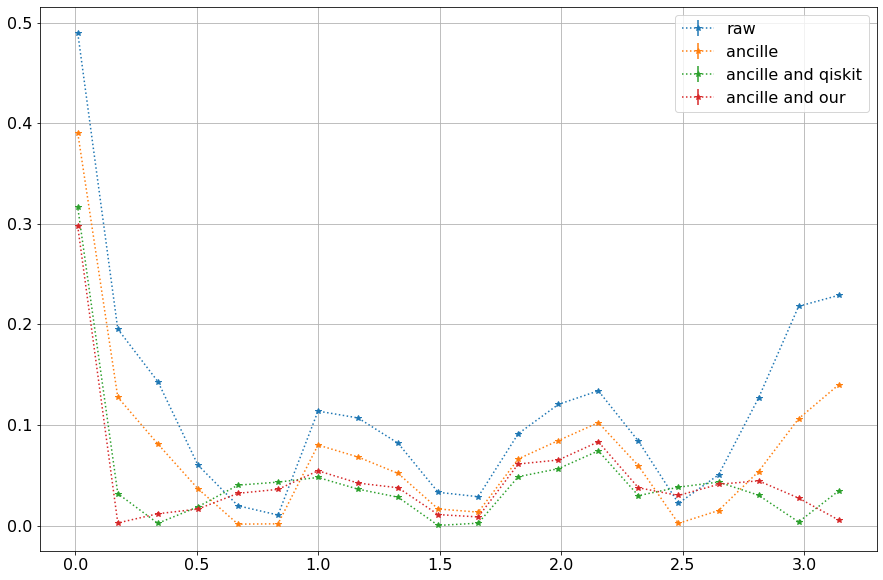

In [56]:
time_range=time_range[::-1]
plt.errorbar(time_range, diff_raw,fids_dev["011"][:,0],linestyle=':',marker="*",label="raw")
plt.errorbar(time_range, diff_anc,fids_dev["011"][:,1],linestyle=':',marker="*",label="ancille")
plt.errorbar(time_range, diff_anc_qisk,fids_dev["011"][:,2],linestyle=':',marker="*",label="ancille and qiskit")
plt.errorbar(time_range, diff_anc_our,fids_dev["011"][:,3],linestyle=':',marker="*",label="ancille and our")
time_range=time_range[::-1]

plt.legend()
plt.grid()

plt.show()

In [18]:
plt.errorbar(time_range, fids_mean[:,0],fids_dev[:,0],linestyle=':',marker="*",label="raw")
plt.errorbar(time_range, fids_mean[:,1],fids_dev[:,1],linestyle=':',marker="*",label="ancille")
plt.errorbar(time_range, fids_mean[:,2],fids_dev[:,2],linestyle=':',marker="*",label="ancille and qiskit")
plt.errorbar(time_range, fids_mean[:,3],fids_dev[:,3],linestyle=':',marker="*",label="ancille and our")
plt.plot([0,np.pi],[1,1],color="gray")
plt.legend()
plt.grid()

plt.show()

TypeError: unhashable type: 'slice'

In [ ]:
if check==[0] or check==0:
    c_auss="noc" 
else:
    c_auss="yesc"

dati=("#%d_%d_%d_%.4f_%s_%s \n" %(shots, reps, precision, steps, c_auss, evo_type))
nome="fid_vs_time_09-03_simu_01.txt"

#f = open("dati_esame_ruben/" + nome, "w")
f.write(dati)

for i in range(n_t):
    f.write("%.5f " %(time_range[i]))
    for j in range(4):
        f.write("%.5f " %(fids_mean[i,j]))
        f.write("%.5f " %(fids_dev[i,j]))
    f.write("\n")

f.close()